# allganize-RAG-Evaluation data + multimodal search
## Methodology
```
1. Load DoclingPDFReader
    1-1. Initialize Docling Converter
    1-2. Initialize PSIKing Reader
2. Load PDF File Data
3. Ingest Data
    3-1. (Reader) PDF File -> PSIKing Document
    3-2. (Splitter) Chunk Documents
4. Embed
5. Insert into DocumentStore, VectorStore
    5-1. Insert to DocStore
    5-2. Insert to VectorStore
6. Query
```

## Settings
* model: `baai/bge-visualized` (bge-m3 weight)
* data: real-life pdf files from `allganize-RAG-Evaluation-Dataset-KO`
    * https://huggingface.co/datasets/allganize/RAG-Evaluation-Dataset-KO
    * use 10 'finance' domain files

In [1]:

import json
import os

from pathlib import Path
import time
from typing import Any, Dict, List, Optional

import pandas as pd
from pydantic import BaseModel
from tqdm import tqdm

from config import settings
# Artifacts should contain model weights downloaded using `docling-tools models download`
# Typically set to `~/.cache/docling/models`
os.environ["DOCLING_ARTIFACTS_PATH"] = settings.docling_artifacts_path

In [2]:
## Import Core Schemas
from psiking.core.base.schema import Document, TextNode, ImageNode, TableNode

# 1. Load DoclingPDFReader

## 1-1. Initialize Docling Converter

In [3]:
from docling_core.types.doc import PictureItem

from docling.datamodel.base_models import InputFormat

from docling.datamodel.pipeline_options import (
    AcceleratorDevice,
    VlmPipelineOptions,
    PdfPipelineOptions,
    PictureDescriptionApiOptions,
    ResponseFormat,
    TableStructureOptions,
    TableFormerMode
)
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline
from docling.datamodel.pipeline_options_vlm_model import (
    ApiVlmOptions,
    InferenceFramework,
    InlineVlmOptions,
    ResponseFormat,
    TransformersModelType
)

In [4]:
pipeline_options = PdfPipelineOptions()

# If force_backend_text = True, text from backend will be used instead of generated text
pipeline_options.force_backend_text = False
pipeline_options.generate_picture_images = True

pipeline_options.images_scale = 1.5
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True
pipeline_options.do_ocr = False

# TableStructure
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options = TableStructureOptions(mode=TableFormerMode.ACCURATE)

pipeline_options.accelerator_options.device = AcceleratorDevice.MPS

In [5]:
# Picture Annotation (picture_description_options) using VLM
# https://docling-project.github.io/docling/examples/pictures_description_api/

# "Describe the image in three sentences. Be consise and accurate.",
DESCRIPTION_INSTRUCTION = '''주어진 이미지에대해 2가지 정보를 반환합니다.
* description: 최대 2문장 정도로 이미지에 대한 간결한 설명
* text: 이미지 내에서 인식된 모든 텍스트
다음 JSON 형식으로 반환하세요 {"description": str, "text": str}'''

class ImageDescription(BaseModel):
    description: str
    text: str

def vllm_local_options(
    base_url: str,
    api_key: str,
    model: str
):
    options = PictureDescriptionApiOptions(
        url=f"{base_url}/v1/chat/completions",
        headers = {
            'Authorization': f'Bearer {api_key}'
        },
        params=dict(
            model=model,
            seed=42,
            max_completion_tokens=8192,
            temperature=0.9,
            extra_body={"guided_json": ImageDescription.model_json_schema()}
        ),
        prompt=DESCRIPTION_INSTRUCTION,
        timeout=180,
    )
    return options

pipeline_options.do_picture_description = True
pipeline_options.enable_remote_services = True

print(settings.vlm_model)
pipeline_options.picture_description_options=vllm_local_options(
    base_url=settings.vlm_base_url,
    api_key=settings.vlm_api_key,
    model=settings.vlm_model
)

vision


In [8]:
converter = DocumentConverter(
    allowed_formats = [
        InputFormat.PDF,
    ],
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options,
        ),
    }
)

## 1-2. Initialize PSIKing Reader

In [9]:
from psiking.core.reader.pdf.docling_reader import DoclingPDFReader

# initalize reader
reader = DoclingPDFReader(converter=converter)

# 2. Load PDF File Data
* 10 pdf files, convert to image with pdf2image

In [10]:
# PDF File directory
pdf_dir = os.path.join(settings.data_dir, "retrieval_dataset/allganize-RAG-Evaluation-Dataset-KO/finance")
pdf_fnames =[x for x in os.listdir(pdf_dir) if x.endswith(".pdf")]
print("num files:", len(pdf_fnames))
pdf_fnames[:10]

num files: 10


['★2019 제1회 증시콘서트 자료집_최종★.pdf',
 '240409(보도자료) 금융위 핀테크 투자 생태계 활성화 나선다.pdf',
 '2024년 3월_3. 향후 통화신용정책 방향.pdf',
 '133178946057443204_WP22-05.pdf',
 '240130(보도자료) 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '130292099630937500_KIFVIP2013-10.pdf',
 '2024년 3월_2. 통화신용정책 운영.pdf',
 '[별첨] 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '240320(보도자료) 금융권의 상생금융 추진현황.pdf',
 '한-호주 퇴직연금 포럼_책자(최종).pdf']

# 3. Ingest Data

## 3-1. (Reader) PDF File -> PSIKing Document

In [11]:
# Convert pages to image
documents = []
failed_fnames = []
for doc_i, fname in tqdm(enumerate(pdf_fnames[:3])):
    file_path = os.path.join(pdf_dir, fname)
    try:
        document = reader.run(
            file_path,
            extra_info = {
                "source_id": f"allganize-RAG-Evaluation-Dataset-KO/finance/{doc_i}", # arbitrary id
                "domain": "finance",
                "source_file": fname
            }
        )
    except Exception as e:
        print("[READER] failed {} - {}".format(fname, str(e)))
        failed_fnames.append(fname)
        continue
    document.nodes = document.nodes
    documents.append(document)
    
for node in document.nodes[:3]:
    print(type(node))

3it [05:56, 118.77s/it]

<class 'psiking.core.base.schema.TextNode'>
<class 'psiking.core.base.schema.TextNode'>
<class 'psiking.core.base.schema.TableNode'>


In [12]:
print(len(documents))

3


In [13]:
document.metadata

{'source_id': 'allganize-RAG-Evaluation-Dataset-KO/finance/2',
 'domain': 'finance',
 'source_file': '2024년 3월_3. 향후 통화신용정책 방향.pdf'}

In [ ]:
# image = document.nodes[0].image

# # Crop to half
# width, height = image.size
# left_half = image.crop((0, 0, width, height//2))
# left_half

## 3-2. (Splitter) Chunk Documents
1. merge text nodes with `TextNodeMerger`
2. split texts into chunks with `LangchainRecursiveCharacterTextSplitter`

In [14]:
from psiking.core.processor.document.text_merger import TextNodeMerger
# Split Documents page-level
merger = TextNodeMerger()

merged_documents = []
for document in documents:
    merged_document = merger.run(document)
    merged_documents.append(merged_document)

In [15]:
# merged_documents[0]
merged_documents[0].nodes[0]

TextNode(id_='829f5a8e-470d-4591-9d12-bd0a7fc60151', metadata={'page_no': 1}, text_type=<TextType.PLAIN: 'plain'>, label=<TextLabel.PLAIN: 'plain'>, resource=MediaResource(data=None, text='증권사 리서치센터장, 자산운용사 대표와 함께하는 제1회 증시 콘서트\n2019 하반기 증시 대전망\n|\xa0일\xa0시\xa0| 2019.\xa07.\xa02\xa0(화)\xa014:30\n|\xa0장\xa0소\xa0| 금융투자협회\xa03층\xa0불스홀', path=None, url=None, mimetype=None))

In [16]:
# 3. Run Splitter
from psiking.core.splitter.text.langchain_text_splitters import LangchainRecursiveCharacterTextSplitter

splitter = LangchainRecursiveCharacterTextSplitter(
    chunk_size = 1024,
    chunk_overlap = 128
)

chunks = []
for document in merged_documents:
    document_chunks = []
    source_id = document.id_
    for i, node in enumerate(document.nodes):
        # Run Splitter
        if isinstance(node, TextNode):
            try:
                split_nodes = splitter.run(node)
            except Exception as e:
                print(i, node)
                print(str(e))
                raise e
        else:
            split_nodes = [node]
        
        # Create New Document
        for split_node in split_nodes:
            # Each Document contains single node
            chunk = Document(
                nodes=[split_node],
                metadata={
                    "source_id": source_id,
                    "domain": document.metadata["domain"],
                    "source_file": document.metadata['source_file'],
                }
            )
            document_chunks.append(chunk)
    chunks.extend(document_chunks)
print(len(chunks))

423


# 4. Embed

In [17]:
## Load Model
import torch
from visual_bge.modeling import Visualized_BGE

# Load Colpali engine
bge_m3_model_dir = os.path.join(
    settings.model_weight_dir, "embedding/bge-m3"
)
visualized_model_dir = os.path.join(
    settings.model_weight_dir, "embedding/baai-bge-visualized/Visualized_m3.pth"
)

model = Visualized_BGE(
    model_name_bge = bge_m3_model_dir,
    model_weight= visualized_model_dir
)
model.eval()
print("Loaded Model")

/opt/miniconda3/envs/psiking/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loaded Model


In [18]:
from psiking.core.embedder.flagembedding import (
    VisualizedBGEInput, 
    LocalVisualizedBGEEmbedder
)
embedder = LocalVisualizedBGEEmbedder(
    model=model
)

In [19]:
model.dtype

torch.float32

In [20]:
def prepare_embedding_input(chunk: Document):
    # Single 
    node = chunk.nodes[0]
    if isinstance(node, TextNode):
        return VisualizedBGEInput(
            text=node.text
        )
    elif isinstance(node, ImageNode) or isinstance(node, TableNode):
        return VisualizedBGEInput(
            text="{} {}".format(
                node.caption, node.text
            ),
            image=node.image
        )
        
inputs = [prepare_embedding_input(x) for x in chunks]

In [21]:
embeddings = embedder.run(inputs, batch_size = 4, disable_tqdm=False)

100%|██████████| 71/71 [02:20<00:00,  1.98s/it]


In [22]:
# (num_chunks, seq_len, embedding_dim)
print(len(embeddings))
print(len(embeddings[0]))

423
1024


# 5. Insert into DocumentStore, VectorStore
* intialize qdrant in-memory

## 5-1. Insert to DocStore

In [33]:
from psiking.core.storage.docstore.in_memory import InMemoryDocumentStore

In [34]:
doc_store = InMemoryDocumentStore()

In [35]:
doc_store.add(chunks)

In [37]:
doc_store.count()

423

## 5-2. Insert to VectorStore

In [23]:
from qdrant_client import QdrantClient
from psiking.core.storage.vectorstore.qdrant import QdrantSingleVectorStore

# initialize client
client = QdrantClient(":memory:")
collection_name = "allganize-finance"

vector_store = QdrantSingleVectorStore(
    collection_name=collection_name,
    client=client
)

In [24]:
from qdrant_client.http import models

embedding_dim = 1024

vector_store.create_collection(
    on_disk_payload=True,  # store the payload on disk
    vectors_config = models.VectorParams(
        size=embedding_dim,
        distance=models.Distance.COSINE,
        on_disk=True,
    )
)

In [25]:
vector_store.add(
    documents=chunks,
    embeddings=embeddings,
    metadata_keys=["source_file", "source_id", "title"]
)

In [26]:
chunks[0].id_

'a49c0bdf-d7eb-410f-af4f-aad252df6cbf'

In [27]:
points = vector_store._client.retrieve(
    collection_name=vector_store.collection_name,
    ids=[chunks[0].id_],
    with_vectors=True
)

In [28]:
print(points[0].id)
print(points[0].payload)
print(len(points[0].vector))

a49c0bdf-d7eb-410f-af4f-aad252df6cbf
{'source_id': '18bc9c4a-4792-4091-ac48-5047e79726ff', 'source_file': '★2019 제1회 증시콘서트 자료집_최종★.pdf'}
1024


# 6. Query

In [29]:
import numpy as np
from psiking.core.storage.vectorstore.schema import (
    MetadataFilters,
    FilterOperator,
    VectorStoreQuery,
    VectorStoreQueryMode,
    VectorStoreQueryOptions,
)   

In [30]:
# Use random query embedding
query_embedding = np.random.randn(1024)

vsquery=VectorStoreQuery(
    dense_embedding=query_embedding
)
vsoptions=VectorStoreQueryOptions(
    mode=VectorStoreQueryMode.DENSE,
    top_k=10
)

In [31]:
points = vector_store.query(
    query=vsquery,
    options=vsoptions
)

In [32]:
points

[ScoredPoint(id='e4522d3e-6605-40ef-87a9-e1760d08e885', version=0, score=0.09474180884550573, payload={'source_id': '18bc9c4a-4792-4091-ac48-5047e79726ff', 'source_file': '★2019 제1회 증시콘서트 자료집_최종★.pdf'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='86a1ff29-a085-4f0a-89d0-c5181dd34de3', version=0, score=0.0899249373343662, payload={'source_id': '9ae50d69-3fe2-4c46-a4f0-88f18e0a8ab6', 'source_file': '2024년 3월_3. 향후 통화신용정책 방향.pdf'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='54d21af3-3978-4e8e-8fa3-7b8875e155f1', version=0, score=0.089485415345183, payload={'source_id': '18bc9c4a-4792-4091-ac48-5047e79726ff', 'source_file': '★2019 제1회 증시콘서트 자료집_최종★.pdf'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='24a315a9-769f-4e7f-a3ce-3eee30a83d85', version=0, score=0.08839935042054466, payload={'source_id': '18bc9c4a-4792-4091-ac48-5047e79726ff', 'source_file': '★2019 제1회 증시콘서ᄐ

In [41]:
# Get Retrieved Result from docstore
retrieved_doc_id = points[0].id

retrieved_doc = doc_store.get(retrieved_doc_id)[0]

In [44]:
nodes = retrieved_doc.nodes
print(len(nodes))

1


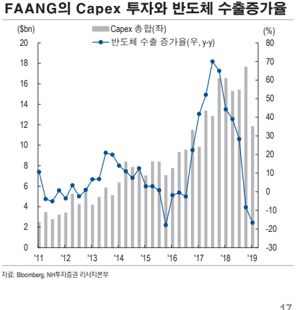

In [46]:
nodes[0].image